## Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from tqdm.auto import tqdm

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver

from qiskit.converters import circuit_to_dag, dag_to_circuit

# Basic Demo and debugging of the xQAOA solver. 

## Problem Setup and Classical Solutions

To begine we initialize our hard knapsack distribution, including the capacity constraint. We end with a plot of all the items in the knapsack and their values and weights.

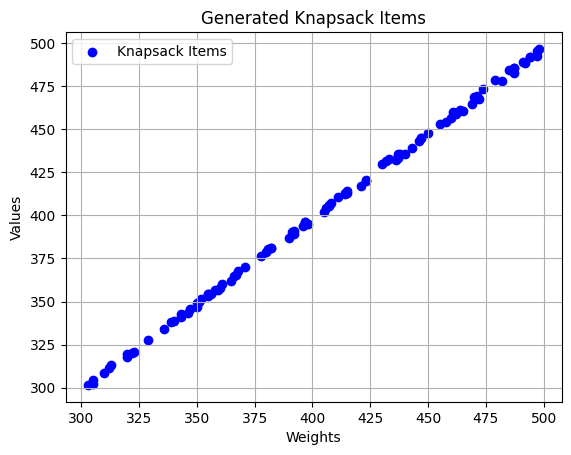

In [100]:
from collections import Counter

n = 100  # Number of items
#d = 4  # Technical term in definition of profit distribution setting how far values can differ from weights
frac = 0.3 # Fraction of total weight to set as capacity

def generate_random_ratio(n, ratio_range = 0.005):
    weights = np.random.randint(300, 500, n)
    ratios = np.random.uniform(1- ratio_range, 1, n)
    values = weights * ratios
    return weights, values

[weights,values] = generate_random_ratio(n, ratio_range=0.01) # create the list of knapsack items

capacity = frac * np.sum(weights)  # Set weight limit to some % of total weight

# Plot the knapsack items
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

Note the relationship between item weights and value is essentially linear with value equal to the weight rounded down to the nearest multiple of $d$. 

A useful way to visualize this is to plot the ratio of value/weight against the weights. 

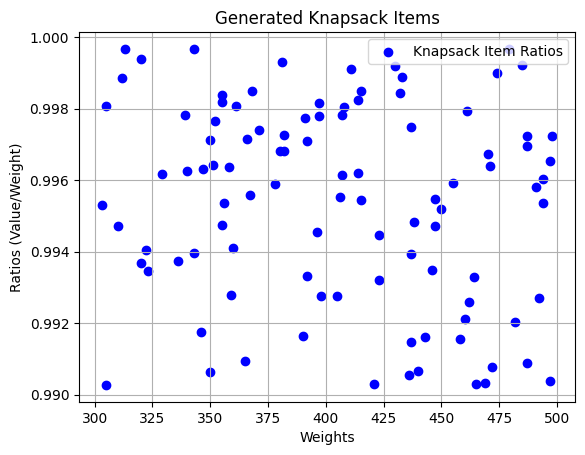

In [101]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now lets solve the problem with Gurobi and plot the optimal solution.

Knapsack Capacity: 12145.199999999999
Total Value of optimal solution: 12125.3702951072
Total Weight of optimal solution: 12145
Runtime: 0.013356 seconds


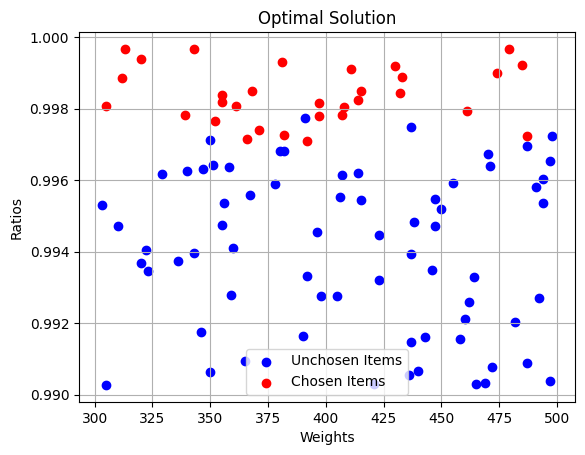

In [102]:
# Solve the knapsack problem using Gurobi
result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 11537.616372945266
Greedy Solution Weight: 11552


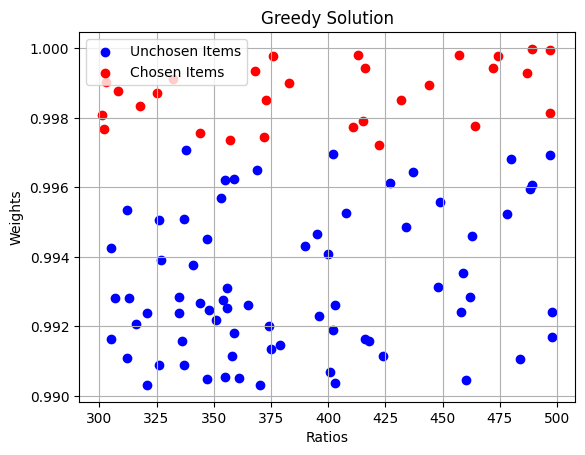

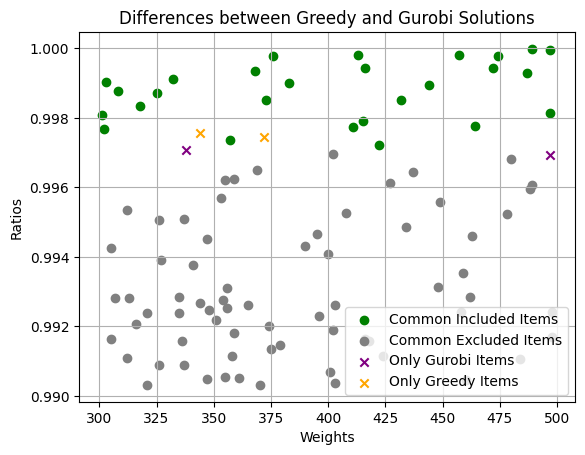

Gurobi solution obtains a value 118.2647 above the greedy solution.
This corresponds to greedy being a fraction 0.0101 off optimal.


In [6]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()

print(f"Gurobi solution obtains a value {optimal_value - greedy_value:.4f} above the greedy solution.")
print(f"This corresponds to greedy being a fraction {(optimal_value - greedy_value)/optimal_value:.4f} off optimal.")


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

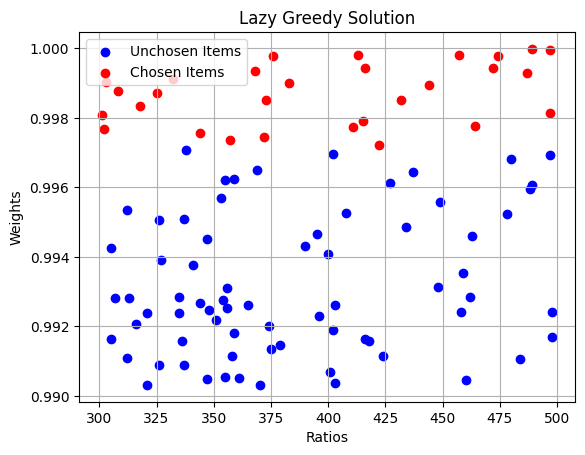

In [7]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



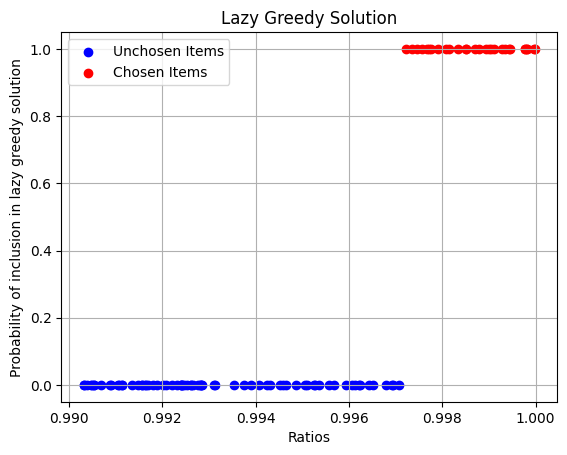

In [8]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.legend()
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k. Setting k = infinity produces the lazy greedy distribution above, while setting k = 0 produces a uniform distribution with expected weight equal to the capacity of knapsack. 

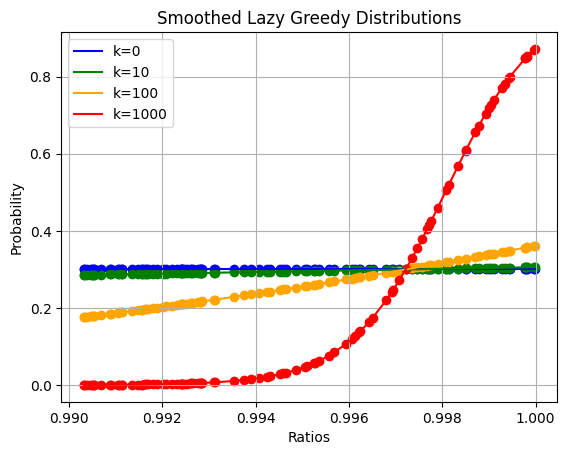

In [9]:
def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    # First find the cutoff ratio for the lazy greedy solution.
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, values / weights, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution]) 
    # Then set some constants so that in the limit of k = 0 we have the correct uniform distribution.
    uniform_probability = np.sum(weights) / capacity

    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

# Lets plot some solutions for different values of k
k_values = [0, 10, 100, 1000]
colours = ['blue', 'green', 'orange', 'red']
plt.figure()
for i in range(len(k_values)):
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_values[i])
    plt.scatter(ratios, smoothed_distribution, color=colours[i], marker='o')
    # plot a line through the points
    ordered_indices = np.argsort(ratios)
    plt.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices], color=colours[i], label=f'k={k_values[i]}')
plt.title('Smoothed Lazy Greedy Distributions')
plt.xlabel('Ratios')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


Note that our "solution" is now a probability distribution. We can repeatedly sample from this distribution to understand the quality of the solutions our warm start gives. An important observation is that this distribution will sometimes give solutions which do not respect the capacity restraints of thte knapsack. We must filter those out to get an accurate understanding of the solution quality.  

Best valid solution value is: 11588.5323193033
Worst invalid solution is: 11986.650688473355
Optimal solution value is: 11655.881094608101
Probability of valid samples: 0.996
Approximation ratio of valid samples: 0.7324


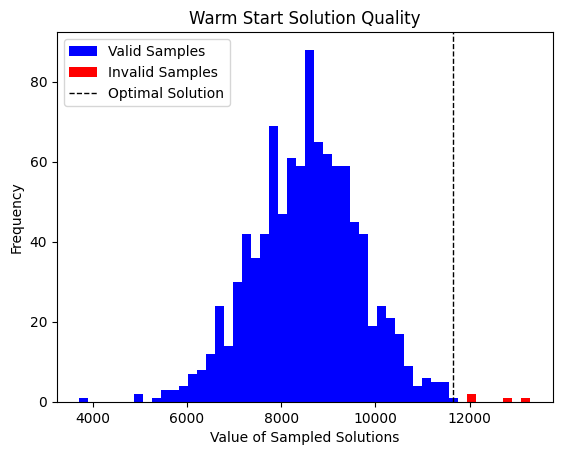

In [10]:
# We will pick k = 1000 since it gives a gives a good balance between the uniform and lazy greedy distributions.
k = 1000
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples = 1000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approxmation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title('Warm Start Solution Quality')
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approxmation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an identical ratio we use weight as a tiebreaker.

In [ ]:
warm_start_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)


As a sanity check, we compute the output probabilities of each qubit in the circuit, and check that the resulting distribution matches the input distribtuion. 

This also gives us an opportunity to introduce the notion of a lightcone estimator. The key observation is that in order to get expectation values give Pauli term we only need to simulate the gates in the backwards lightcone of that Pauli. For the moment we are just estimating single Pauli Z terms, and our backwards lightcone is just a single qubit. 

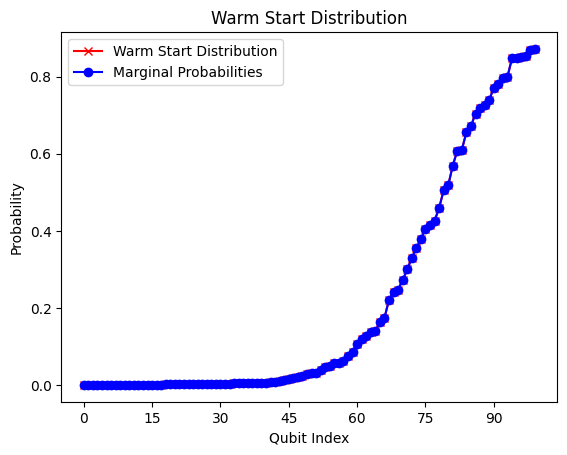

In [ ]:
from qiskit.quantum_info import Pauli
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import LightCone, RemoveBarriers
from qiskit.primitives import StatevectorEstimator

exact_estimator = StatevectorEstimator()
observables = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(n)]

def light_cone_estimate(qc, observable, estimator=exact_estimator):
    """
    Estimates the expectation value of the observable using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        observable (Pauli): The observable to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    pauli_str = observable.to_label()
    # print(f"Pauli string for the observable: {pauli_str}")

    # Find the non-trivial pauli operators in the observable and their indices
    non_trivial_pauli = pauli_str.replace('I', '')
    active_indices = [(len(pauli_str)-1-i) for i, p in enumerate(pauli_str) if p != 'I']
    # print(non_trivial_pauli)
    # print(active_indices)

    # Apply the light cone pass to the circuit
    light_cone_pass = LightCone(bit_terms=non_trivial_pauli, indices=active_indices)
    pm = PassManager([RemoveBarriers(),light_cone_pass])
    red_qc = pm.run(qc)

    # Now we've got to remove the unused wires from our circuit so that exact_estimator doesn't choke.
    # We do this by converting to a DAG, then identifying and removing the idle wires.
    # We also need to remove the corresponding Pauli operators from the observable. 
    # Note the remaining Pauli observable can be larger than non_trivial_pauli above, since it may contain
    # some I corresponding to qubits in the backwards lightcone of the active qubits.
    red_dag = circuit_to_dag(red_qc)
    qubits_to_remove = list(red_dag.idle_wires())
    indices_to_remove = [len(pauli_str) - 1 - red_dag.find_bit(q).index for q in qubits_to_remove]
    for q in qubits_to_remove:
        red_dag.remove_qubits(q)
    truncated_observable = Pauli(''.join([p for i, p in enumerate(pauli_str) if i not in indices_to_remove]))
    red_qc = dag_to_circuit(red_dag)

    # Run the estimator with the smaller circuit and the truncated observable.
    exact_sim = exact_estimator.run([(red_qc, truncated_observable)])
    
    return exact_sim.result()[0].data.evs

# Get Pauli Z expectation values (exact) using the lightcone method, then convert to probabilities
pauli_z_evs = [light_cone_estimate(qc, obs) for obs in observables]
marginal_probs = (1 - np.array(pauli_z_evs)) / 2

# Plot probabilities and compare with warm start distribution. Note we have to reverse the order of the qubits due to little-endian ordering.
plt.plot(qubit_ordered_distribution[::-1], marker='x', linestyle='-', color='red', label='Warm Start Distribution')
plt.plot(marginal_probs, marker='o', linestyle='-', color='blue', label='Marginal Probabilities')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Warm Start Distribution')
plt.xlabel('Qubit Index')
plt.ylabel('Probability')   
plt.legend()
plt.show()


## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer. This mixer takes as input variabels $\theta, p_1,$ and $p_2$, in addition to a parameter $\beta$ which controls the mixer strength as in standard QAOA. To explain this mixer, we first define the *Copula Distribution* $p_{cop}$ to be a distribution over two bits with: 

$$
\begin{align}
p_{cop}(0,0) &= (1 - p_1)(1-p_2) + \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(0,1) &= (1 - p_1)(p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,0) &= (p_1)(1-p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,1) &= (p_1)(p_2) + \theta p_1 p_2(1 - p_1)(1-p_2)
\end{align}
$$

Straightforward computation shows that this distribution has single-bit marginal probabilities matching the proabilities $p_1$ and $p_2$ used in its definition. The $\theta$ parameter takes values in $[-1,1]$ and controls whether the two bits are correlated or anti-correlated in this distribution. When $\theta = -1$ bits are maximally anti-correlated, and $\theta = 1$ corresponds to bits being maximally correlated.  

Now we construct a unitary $R_{cop}$ satisfying $R_{cop}\ket{00} = \ket{p_{cop}}$ and define the mixer Hamiltoniaon $H_{cop} = -R_{cop}^\dagger (ZZ) R_{cop}$. Then the state $\ket{p_{cop}} = \sum_{x_1, x_2} \sqrt{p_{cop}(x_1,x_2)} \ket{x_1, x_2}$ is the ground state of the Hamiltonian with eigenvalue $-2$, and all other eigenstates have eigenvalue $\geq 0$. Finally, the Copula mixer in terms of $\beta$ is defined by 

$$
\begin{align}
U_{cop, \beta} = \exp(-i \beta H_{cop}).
\end{align}
$$

Note that setting $\beta = 0$ turns off the Copula mixer. Since the eigenvalues of $H_{cop}$ are multiples of two, **the mixer is period in $\beta$ with a periodicity of $\pi$**, i.e. we have $U_{cop, \ \beta} = U_{cop,\ \beta + \pi}$ for any $\beta$. 

In [15]:
def construct_cop(p_1, p_2, beta, theta = -1):
    """
    Constructs a two qubit copula mixer with the given parameters.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum on which we add the Copula mixer.
        p_1 (float): Probability p_1 in the definition of the copula mixer.
        p_2 (float): Probability p_2 in the definition of the copula mixer.
        beta (float): The strength of the copula mixer.
        theta (float): The theta parameter of the copula mixer, which controls whether qubits are correlated or anti-correlated. Should take values in [-1,1] and defaults to -1, which means maximum anticorrelation.

    Returns:
        QuantumCircuit: The quantum circuit with the copula mixer added.
    """

    # We first construct a rotation operator designed to rotate the |00> state to the |p_cop> state.
    rotation_circuit = QuantumCircuit(2)
    phi_1 = 2 * np.arcsin(np.sqrt(p_1))  
    p_2_given_1 = (p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2))/ p_1
    phi_2_given_1 = 2 * np.arcsin(np.sqrt(p_2_given_1))
    p_2_given_not1 = ((1- p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)) / (1 - p_1)
    phi_2_given_not1 = 2 * np.arcsin(np.sqrt(p_2_given_not1))

    rotation_circuit.ry(phi_1, 0)  # Rotate first qubit to the correct marginal distribution
    rotation_circuit.cry(phi_2_given_1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |1>
    rotation_circuit.x(0)  # Flip qubit 1
    rotation_circuit.cry(phi_2_given_not1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |0>
    rotation_circuit.x(0)  # Undo flip

    copula_mixer = QuantumCircuit(2)
    copula_mixer.compose(rotation_circuit.inverse(), inplace=True) # rotate |p_cop> to |00>
    copula_mixer.barrier()  
    # In this rotated basis, the copula mixer is diagonal, so we can impliment with RZ gates.
    copula_mixer.rz(-2* beta, 0)  
    copula_mixer.rz(-2 *beta, 1)  
    copula_mixer.barrier()  
    copula_mixer.compose(rotation_circuit, inplace=True) # rotate |00> back to |p_cop>

    return copula_mixer
    

Now lets run some basic tests to verify the copula is working as intended. 

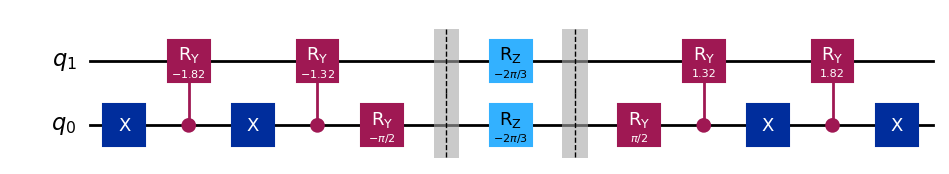

Eigenvalues of the copula mixer: 

Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.7071-0.0000j |00>  + 0.0000+0.0000j |01> + -0.0000-0.0000j |10> + 0.7071+0.0000j |11>
Eigenvalue: -0.5000-0.8660j
Eigenvector: 0.5590+0.0000j |00>  + -0.4330+0.0000j |01> + -0.4330-0.0000j |10> + 0.5590+0.0000j |11>
Eigenvalue: -0.5000+0.8660j
Eigenvector: 0.4330+0.0000j |00>  + 0.5590+0.0000j |01> + 0.5590+0.0000j |10> + 0.4330-0.0000j |11>
Eigenvalue: 1.0000-0.0000j
Eigenvector: 0.2963+0.1538j |00>  + 0.6233+0.0000j |01> + -0.6233-0.0000j |10> + -0.2963-0.1538j |11>

We expect an eigenvector: 0.4330 |00> + 0.5590 |01> + 0.5590 |10> + 0.4330 |11>
with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = -0.5000+0.8660j


In [16]:
from qiskit.quantum_info import Operator 

# Test the copula mixer construction.
test_copula_mixer = construct_cop(0.5, 0.5, np.pi/3)

display(test_copula_mixer.draw('mpl', scale=1, idle_wires=False, fold=-1, reverse_bits=True))

# This unitary is small enough we can just check its eigenvectors and eigenvalues directly. 
cop_unitary = Operator(test_copula_mixer).data
eigenvalues, eigenvectors = np.linalg.eig(cop_unitary)

print("Eigenvalues of the copula mixer: \n")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue: {ev:.4f}")
    print(f"Eigenvector: {eigenvectors[0,i]:.4f} |00>  + {eigenvectors[1,i]:.4f} |01> + {eigenvectors[2,i]:.4f} |10> + {eigenvectors[3,i]:.4f} |11>")  


p_1 = 0.5
p_2 = 0.5
theta = -1
p_cop_00 = (1 - p_1) * (1 - p_2) + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_01 = (1 - p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_10 = p_1 * (1 - p_2) - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_11 = p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)

print(f"\nWe expect an eigenvector: {np.sqrt(p_cop_00):.4f} |00> + {np.sqrt(p_cop_01):.4f} |01> + {np.sqrt(p_cop_10):.4f} |10> + {np.sqrt(p_cop_11):.4f} |11>")
print(f"with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = {np.exp(2j * np.pi / 3):.4f}")


Now we can construct the "ring" copula mixer proposed in https://arxiv.org/pdf/2108.08805. The idea is to visualize the qubits as lying in a ring, and to apply the two qubit copula mixer defined above between nearest neighbour terms on the ring. We get the probabilities $p_i$ and $p_j$ used in the defintion of each copula mixer from the warm start distribution we used to initialize our quantum state. 

This should have the effect of leaving the qubits with high ratios of value-to-weight as very likely in the knapsack, anad the low ratio qubits as very likely excluded from the knapsack, but it will encourage mixing between the qubits with middling value. This mixing should anti-correlate nearby terms -- adding a item to the knapsack while removing an item with similar ratio -- and thus approximately preserve the overall knapsack weight.

In [17]:
def add_ring_copula(quantum_circuit, probability_dist, beta):
    """
    Constructs a ring copula mixer on the given quantum circuit.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the ring copula mixer.
        probability_dist (np.ndarray): The probability distribution to use for the copula mixer.
    """
    n = len(probability_dist)
    for i in range(1,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    for i in range(2,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    quantum_circuit.barrier()  
    return quantum_circuit

To complete the setup for xQAOA we also need to define a cost function. Because we have encoded a (soft) version of our constraints into our mixer we leave constraints out of this cost function. But then it is particularly straightfoward -- we simply sum the values of each of the items included in the knapsack. 

As in standard QAOA we also multiple our cost function by a $\gamma$ parameter. Because we want this parameter to take values in $[0,2\pi]$, we will normalize all our values by the max possible value so the normalized values lie in $[0,1]$. 

In [18]:
def add_knapsack_cost_function(quantum_circuit, values, gamma):
    """
    Adds a cost function to the quantum circuit that sums the values of the items included in the knapsack.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the cost function.
        values (np.ndarray): The values of the items in the knapsack.
        gamma (float): The strength of the cost function.
    """

    max_value = np.max(values)
    n = len(values) 
    for i in range(n):
        quantum_circuit.p(gamma * values[i]/max_value, i)  # Apply RZ gate with angle proportional to value
    quantum_circuit.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

Finally, we can put this all together and visualize the circuit with the warm start initialization, one layer of the cost unitary, and one layer of the mixer. 

In [20]:
# Now lets plot a sample of our circuit with one layer of the ring copula mixer. 
# Picking arbitrary values of beta and gamma for now.
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)
#qc.draw('mpl', scale=0.5, idle_wires=False, fold=-1, reverse_bits=True)

## Optimizing Values of Beta and Gamma

### Defining the Objective to Optimize 

Now that our basic circuit is set up, we can turn our attention to the important task of optimizing its variational paramters. The first question to consider is what function we want to optimize. In standard QAOA, the cost function being optimized is the same one which is expoentiated to produce the cost unitary, and that is an option for us as well. 

But there are other options -- we can incorporate the knapsack constraints in the final cost function we optimize against (even though we left them out of the cost unitary). One natural way to do this that avoids the need for slack variables is just to enforce an *equality* constraint -- that the total weight of items in the knapsack match its capacity -- with a penalty term which increases the more this constaint is violated. 

We will define cost functions (expressed as weighted sums of Pauli operators) corresponding to the two approaches above. One nice feature of both these cost functions is that they can be expressed as sums of low weight Pauli operators, meaning that they can be estimated using the lightcone methods defined earlier. 

The first option -- defining a cost function without constraints -- is straightforward. Letting $x_i$ be the indicator random variable indicating if item $i$ is in the knapsack, and $v_i$ be the value of each item in our knapsack. Then our cost function just tries to maximize the value of items in the knapsack:

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i.
\end{align}$

By we can express the expected value of indicator random variable $x_i$ in terms of the expectation value of a Pauli $Z_i$ operating on the $i$-th qubit: $\langle x_i \rangle = \langle (1 - Z_i)/2 \rangle$. So we can also express our cost an sum of Pauli terms which, when measured, gives us the expected cost. 

$\begin{align}
f_{cost}(Z) = \sum_i v_i (1 - Z_i)/2 = \sum_i (-v_i) Z_i / 2 + \text{const}.
\end{align}$

Since the constant terms and multiplicative factors do not affect the overall optimization, we optimize the simpler cost function 

$\begin{align}
f_{cost}(Z) = \sum_i (-v_i) Z_i.
\end{align}$


In [21]:
from qiskit.quantum_info import SparsePauliOp

def values_only_cost(values):
    """
    Constructs a cost function that sums the values of the items included in the knapsack.
    
    Args:
        values (np.ndarray): The values of the items in the knapsack.
        
    Returns:
        SparsePauliOp: A sparse Pauli operator representing the cost function.
    """

    PauliZ_obs = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(len(values))]    
    Weights = -values[::-1]  # Reverse the order of the values to match little-endian ordering
    return SparsePauliOp(PauliZ_obs, Weights)

The second option -- defining a cost function which includes a soft equality constraint -- requires some more math. We let $v_i$ denote the value of the $i$-th knapsack item, $w_i$ denote its weight, C be the knapsack capacity and $x_i$ be an indicator random variable indicating whether item $i$ is in the knapsack. Then the cost function we would like to impliment has the form: 

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i - \chi \left( \sum_i x_i w_i - C \right)^2.
\end{align}$

where $\chi$ is a free parameter determining the strength of our equality constraint. We can expand this expression to obtain

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i - \chi \left( \sum_i \sum_j x_i x_j  w_i x_j - 2 C \sum_i x_i w_i + C^2 \right).
\end{align}$

We drop the constant term (since it has no effect on the overall optimization) and replace the other terms with Pauli operators as $x_i = (1 - Z_i)/2$ to obtain

$\begin{align}
f_{cost}(Z) &= \sum_i v_i (1 - Z_i) / 2 - \chi \left( \sum_i \sum_j w_i w_j (1 - Z_i)(1-Z_j) / 4 - C \sum_i w_i (1- Z_i) \right) \\
&= \sum_i -v_i Z_i / 2 - \chi \left(  \sum_i \sum_j w_i w_j (Z_i Z_j - Z_i - Z_j) / 4 + C \sum_i w_i Z_i \right).
\end{align}$

We introduce the shorthand $W = \sum_i w_i$ and continue:

$\begin{align}
f_{cost}(Z) &= \sum_i -v_i Z_i / 2 - \sum_i \sum_j \chi w_i w_j Z_i Z_j + \sum_i \sum_j \chi w_i w_j Z_i / 2 - C \chi \sum_i w_i Z_i \\
&= \sum_i -v_i Z_i / 2 - \sum_i \sum_j \chi w_i w_j Z_i Z_j + \sum_i \chi w_i W Z_i / 2 - C \chi \sum_i w_i Z_i \\
&= - \sum_{i \neq j} \chi w_i w_j Z_i Z_j + \sum_i Z_i (-v_i/2 + \chi (W/2 - C) w_i).
\end{align}$

In the final line we noticed that $Z_i^2 = I$ and shifted by a constant to remove terms where $i = j$ in the first sum. Also we note that the sum as written above ``double counts'' $i,j$ and $j,i$, so we need to include a factor of two in the first term if we want a sum that only includes each $Z_i Z_j$ once. 

We end with a discussion of reasonable values for $\chi$. For now, we will make this number reasonably small to encourage exploration. Our optimal solutions seem to have a weight about 10 away from the knapsack capacity. We set $\chi = 500 * (1/100)^2 = 0.05$, so that having a solution a weight 100 away from optimal is penalized about the same as excluding an item with average value in the distribtuion. 

Now we construct the corresponding Sparse Pauli Operator.

In [ ]:
def values_and_constraint_cost(values, weights, capacity, chi = 0.05):
    """
    Constructs a cost function that sums the values of the items included in the knapsack.
    
    Args:
        values (np.ndarray): The values of the items in the knapsack.
        weights (np.ndarray): The weights of the items in the knapsack.
        capacity (float): The capacity of the knapsack.
        chi (float): A parameter controlling how strongly solutions are penalized for not using the full knapsack capacity. Defaults to 0.05.

    Returns:
        SparsePauliOp: A sparse Pauli operator representing the cost function.
    """

    PauliZ_obs = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(len(values))]    
    PauliZZ_obs = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            PauliZZ_obs.append(Pauli(f'I' * i + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (n - j - 1)))
    weights_sum = np.sum(weights)
    singleZ_coeff = -values[::-1]/2 + chi * (weights_sum/2 - capacity) * weights[::-1]  
    doubleZ_coeff = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            doubleZ_coeff.append(- 2 * chi * weights[len(values) - i - 1] * weights[len(values) - j - 1])
    observables = PauliZ_obs + PauliZZ_obs
    coefficients = np.concatenate((singleZ_coeff, doubleZ_coeff))
    return SparsePauliOp(observables, coefficients)

### Modified Values and Constraints Cost Function
Here we modify the values and constraint cost function defined above to avoid overproduction of invalid solutions. Recall that the cost function was defined as:

$\begin{align}
f_{cost}(x) = \sum_i x_i v_i - \chi \left( \sum_i x_i w_i - C \right)^2.
\end{align}$
    
The first term is maximized when the Hamming weight of the bitstring is maximized (all ones). The second term adds a penalty as the capacity of the knapsack strays away from $C$. But the combined effect of these two terms is to produce a cost function which is maximized when the knapsack is slightly *over*filled -- because the first term shifts the optimal solution towards an all-ones solution.
To adjust for this we can decrease the weight $C$ which the second term concentrates around by an amount to compensate for this shift. But how much should we decrease it by? In all our examples, weights and values are approximately linearly related. If they were exactly linearly related our cost function would have the form:
$\begin{align}
f_{cost}(x) = \sum_i x_i w_i - \chi \left( \sum_i x_i w_i - C \right)^2.
\end{align}$
Letting $X = x_i w_i$ be the total weight assigned to the knapsack we can write this function as
$\begin{align}
f_{cost}(X) = X - \chi \left( X - C \right)^2
\end{align}$

 This function takes it's maximum when
$\begin{align}
f_{cost}'(X) &= 1 - 2 \chi \left( X - C \right)  = 0
\Leftrightarrow X &= C + 1/ (2 \chi)
\end{align}$,
Since we want the maximum to occur at $X = C$, we should use a new constant $C' = C - 1/ (2 \chi)$ in our cost function. So the new cost fuction becomes
$\begin{align}
f_{cost}(x) = \sum_i x_i w_i - \chi \left( \sum_i x_i w_i - C' \right)^2.
= \sum_i x_i w_i - \chi \left( \sum_i x_i w_i - C + 1/(2 \chi) \right)^2.
\end{align}$,
Then we can repeat the same change of variables and simplification as above to obtain a cost function
$\begin{align}
f_{cost}(Z) =& - \sum_{i \neq j}\chi w_i w_j Z_i Z_j / 4 + \sum_i Z_i (-v_i/2 + \chi (W/2 - C') w_i), \\
=& - \sum_{i \neq j} \chi w_i w_j Z_i Z_j / 4 + \sum_i Z_i (-v_i/2 + \chi (W/2 - C + 1/(2\chi)) w_i),
\end{align}$
We construct the corresponding Sparse Pauli Operator below. 

In [23]:
# Modified cost function
def new_values_and_constraint_cost(values, weights, capacity, chi = 0.05):
    """
    Constructs a cost function that sums the values of the items included in the knapsack.
    
    Args:
        values (np.ndarray): The values of the items in the knapsack.
        weights (np.ndarray): The weights of the items in the knapsack.
        capacity (float): The capacity of the knapsack.
        chi (float): A parameter controlling how strongly solutions are penalized for not using the full knapsack capacity. Defaults to 0.05.

    Returns:
        SparsePauliOp: A sparse Pauli operator representing the cost function.
    """

    PauliZ_obs = [Pauli(f'I' * i + 'Z' + 'I' * (n - i - 1)) for i in range(len(values))]    
    PauliZZ_obs = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            PauliZZ_obs.append(Pauli(f'I' * i + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (n - j - 1)))
    weights_sum = np.sum(weights)
    singleZ_coeff = -values[::-1]/2 + chi * (weights_sum/2 - capacity + 1/(2*chi)) * weights[::-1]  
    doubleZ_coeff = []
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            doubleZ_coeff.append(- chi * weights[len(values) - i - 1] * weights[len(values) - j - 1] / 2)
    observables = PauliZ_obs + PauliZZ_obs
    coefficients = np.concatenate((singleZ_coeff, doubleZ_coeff))
    return SparsePauliOp(observables, coefficients)

Let's also define a class that will be useful for computing expectation values below.

In [ ]:
class PauliPoly:
    """A class representing a polynomial of Pauli operators.
    
    Args:
        support (set of Pauli): The support of the polynomial
        monomials (dict[frozenset[(Pauli, int)], float]: The terms (monomials) of the polynomial. Keys give the Pauli terms with multiplicity, values give the coefficients.
    """

    def __init__(self, monomials=None):
        if monomials is not None:
            self.monomials = monomials 
            self._support = {pauli for pauli, _ in monomials.keys()}
        else:
            self.monomials = {}
            self._support = set()

    def add_term(self, paulis, coefficient):
        newkey = frozenset((p, exp) for p, exp in Counter(paulis).items() if exp != 0)
        if newkey in self.monomials:
            self.monomials[newkey] += coefficient
        else:
            self.monomials[newkey] = coefficient
            self._support.update(paulis)
    
    def evaluate(self, evs):
        total = 0.0
        for pauli in self._support:
            if pauli not in evs:
                raise ValueError(f"Expectation value for Pauli {pauli} not provided.")
        for key, coeff in self.monomials.items():
            term_ev = np.prod([evs[pauli]**count for pauli, count in key])
            total += coeff * term_ev
        return total
    
    def get_support(self):
        return self._support
    
def light_cone_decomp(qc, observable):
    """
    Decomposes an observable into products of smaller observables using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit considered.
        observable (Pauli): The observable to estimate.
    
    Returns:
        decomposed_observables (list of Pauli): The list of decomposed observables.
    """

    pauli_str = observable.to_label()

    # Find the non-trivial pauli operators in the observable and their indices
    non_trivial_pauli = pauli_str.replace('I', '')
    active_indices = [(len(pauli_str)-1-i) for i, p in enumerate(pauli_str) if p != 'I']


    # We keep track of the active observables as a dictionary, with the index as the key and the pauli operator as the value.
    active_observables = {active_indices[i]:non_trivial_pauli[i] for i in range(len(active_indices))}

    # Now we imagine a bipartite graph, with all possible indecies on the left and active indices on the right.
    # We add an edge between left and right index if there is a path from input to output in the circuit's lightcone.
    # We represent this graph by an adjacency list, with active indices as keys and the set of touching indices as values.
    
    lightcone_graph = {}

    for j in range(len(active_indices)):
        # print(f"Index: {active_indices[j]} with Pauli: {non_trivial_pauli[j]}")
        light_cone_pass = LightCone(bit_terms=non_trivial_pauli[j], indices=[active_indices[j]])
        pm = PassManager([RemoveBarriers(),light_cone_pass])
        backwards_lightcone_qc = pm.run(qc)
        backwards_lightcone_dag = circuit_to_dag(backwards_lightcone_qc)
        touched_indices = set()
        # print(f"Backwards lightcone for index {active_indices[j]}:")
        for node in backwards_lightcone_dag.op_nodes():
            for q in node.qargs:
                touched_indices.add(backwards_lightcone_dag.find_bit(q).index)
        # print(f"Touched indices: {touched_indices}")
        lightcone_graph[active_indices[j]] = touched_indices
    
    # Now that the lightcone graph has been constructed, we can identify connected components.
    # We only keep track of the active indices, since this is what we need to decompose the observable.
    # Note this code is a little different than standard dfs, but works for our purposes.

    def get_bipartite_connected_component(start_vert, graph):
        component = set()
        vertex_list = list(graph.keys())
        vertex_list.remove(start_vert)
        queue = [start_vert]
        while queue:
            v = queue.pop(0)
            component.add(v)
            for vert_option in vertex_list:
                if graph[vert_option].intersection(graph[v]):
                    queue.append(vert_option)
                    vertex_list.remove(vert_option)
        return component

    components = []    

    while active_observables:
        start_vert = next(iter(active_observables))
        component = get_bipartite_connected_component(start_vert, lightcone_graph)
        components.append({i:active_observables[i] for i in component})
        for i in component:
            del active_observables[i]

    # Finally, convert the components back to Pauli strings.
    componentPauli = [Pauli(''.join(['I' if i not in comp else comp[i] for i in range(len(pauli_str))])) for comp in components]
    # Reversing the order for little-endian. Adam is slightly confused about where above ordering was flipped, but it seems like it was.
    componentPauli = [Pauli(p.to_label()[::-1]) for p in componentPauli]
    return componentPauli

def light_cone_decomp_sparse_pauli(qc, observable):
    """"
    Decomposes a sparse Pauli observable into products of smaller observables using the lightcone method.

    Args:
        qc (QuantumCircuit): The quantum circuit considered.
        observable (SparsePauliOp): The observable to estimate.

    Returns:
        PauliPoly: A polynomial of Pauli operators representing the decomposition.
    """

    pauli_list = observable.paulis
    coefficient_list = observable.coeffs

    pauli_poly = PauliPoly()

    for pauli_term,coeff in zip(pauli_list, coefficient_list):
        decomposed_paulis = light_cone_decomp(qc, pauli_term)
        pauli_poly.add_term(decomposed_paulis, coeff)
    
    return pauli_poly

def light_cone_estimate_Pauli_poly(pauli_poly, qc):
    """
    Estimates the expectation value of a PauliPoly using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        pauli_poly (PauliPoly): The Pauli polynomial to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    support = pauli_poly.get_support()
    support_evs = {pauli: light_cone_estimate(qc, pauli) for pauli in support}
    return pauli_poly.evaluate(support_evs)


In [25]:
from qiskit import QuantumCircuit
print(f"\nNow we run the circuit with a arbitrary beta and gamma to see the effect of the depth one Copula.")
print(f"Setting gamma = 0.1 and beta = pi/3 for now.")
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)

print("In this method first decompose the observable into a PauliPoly, then evaluate the PauliPoly.")
print("Focusing just on the values and constraints cost function for now.")
start_time = time.time()
pauli_poly = light_cone_decomp_sparse_pauli(qc, values_and_constraint_cost(values, weights, capacity))
end_time = time.time()
print(f"Decomposing the observable took {end_time - start_time:.4f} seconds")
start_time = time.time()    
evB_poly = light_cone_estimate_Pauli_poly(pauli_poly, qc)
end_time = time.time()
print(f"Values and constraint cost function of only layer xQAOA is: {evB_poly:.4f}, computed in {end_time - start_time:.4f} seconds")

print("Now using the new cost function with shifted constraint...")
start_time = time.time()
pauli_poly_new = light_cone_decomp_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))  
end_time = time.time()
print(f"Decomposing the observable took {end_time - start_time:.4f} seconds")
start_time = time.time()    
evB_poly_new = light_cone_estimate_Pauli_poly(pauli_poly_new, qc)
end_time = time.time()
print(f"New values and constraint cost function of only layer xQAOA is: {evB_poly_new:.4f}, computed in {end_time - start_time:.4f} seconds")


Now we run the circuit with a arbitrary beta and gamma to see the effect of the depth one Copula.
Setting gamma = 0.1 and beta = pi/3 for now.
In this method first decompose the observable into a PauliPoly, then evaluate the PauliPoly.
Focusing just on the values and constraints cost function for now.
Decomposing the observable took 36.2494 seconds
Values and constraint cost function of only layer xQAOA is: -17329647.5634+0.0000j, computed in 2.3796 seconds
Now using the new cost function with shifted constraint...
Decomposing the observable took 35.2179 seconds
New values and constraint cost function of only layer xQAOA is: 2441446.4612+0.0000j, computed in 2.3261 seconds


Let's now use the lightcome estimator defined previously to compute the objective function achieved in expectation by the output distribution of a quantum circuit. We perform some sanity checks, then compute the performance of the depth one xQAOA mixer for some arbitrary values of $\gamma$ and $\beta$.

In [31]:
def light_cone_estimate_sparse_pauli(qc, observable, estimator=exact_estimator):
    """
    Estimates the expectation value of the observable using the lightcone method.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to run.
        observable (SparsePauliOp): The observable to estimate.
    
    Returns:
        float: The estimated expectation value.
    """

    Pauli_list = observable.paulis
    coefficient_list = observable.coeffs

    Pauli_evs = [light_cone_estimate(qc, Pauli) for Pauli in Pauli_list]
    

    return np.sum(np.array(Pauli_evs) * np.array(coefficient_list)) 


# First a santity check of the values only cost function:

qc = QuantumCircuit(n)
min_val_cost = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
min_val_const_cost = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))

for i in range(n):
    qc.x(i)  
max_val_cost = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
max_val_const_cost = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))

for i in range(n):
    if i not in result_gurobi['selected_items']:
        qc.x(i)
optimal_val_cost = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
optimal_val_const_cost = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))


print(f"First lets investigate the values only cost function:")
print(f"Cost function when all bits are zero (no items in knapsack): {min_val_cost:.4f}")
print(f"Cost function when all bits are one (all items in knapsack): {max_val_cost:.4f}")
print(f"Cost function of optimal (Gurobi) solution: {optimal_val_cost:.4f}")

print(f"\nNow lets investigate the values and constraint cost function:")
print(f"Cost function when all bits are zero (no items in knapsack): {min_val_const_cost:.4f}")
print(f"Cost function when all bits are one (all items in knapsack): {max_val_const_cost:.4f}")
print(f"Cost function of optimal (Gurobi) solution: {optimal_val_const_cost:.4f}")


print("\nNow we investigate our quantum circuit. We start with just the warm-start distribution.")


qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

start_time = time.time()
ev = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
end_time = time.time()
print(f"Values only cost function of warm start is: {ev:.4f}, computed in {end_time - start_time:.4f} seconds")

start_time = time.time()
ev2 = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))
end_time = time.time()
print(f"Values and constraint cost function of warm start is: {ev2:.4f}, computed in {end_time - start_time:.4f} seconds")

qc = add_knapsack_cost_function(qc, values, 0)
qc = add_ring_copula(qc, qubit_ordered_distribution, 0)

ev3 = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
ev4 = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))

print(f"As a sanity check, these values should be the same as above.")
print(f"Values only: {ev3:.4f}, Values and constraint: {ev4:.4f}")

print(f"\nNow we run the circuit with a arbitrary beta and gamma to see the effect of the depth one Copula.")
print(f"Setting gamma = 0.1 and beta = pi/3 for now.")
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)
start_time = time.time()
ev5 = light_cone_estimate_sparse_pauli(qc, values_only_cost(values))
end_time = time.time()
print(f"Values only cost function of only layer xQAOA is: {ev5:.4f}, computed in {end_time - start_time:.4f} seconds")
start_time = time.time()
ev6 = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))
end_time = time.time()
print(f"Values and constraint cost function of only layer xQAOA is: {ev6:.4f}, computed in {end_time - start_time:.4f} seconds")

First lets investigate the values only cost function:
Cost function when all bits are zero (no items in knapsack): -38705.3875+0.0000j
Cost function when all bits are one (all items in knapsack): 38705.3875+0.0000j
Cost function of optimal (Gurobi) solution: -15393.6253+0.0000j

Now lets investigate the values and constraint cost function:
Cost function when all bits are zero (no items in knapsack): -3590144.2588+0.0000j
Cost function when all bits are one (all items in knapsack): -33860767.1912+0.0000j
Cost function of optimal (Gurobi) solution: 3220686.0923+0.0000j

Now we investigate our quantum circuit. We start with just the warm-start distribution.
Values only cost function of warm start is: -22540.0382+0.0000j, computed in 0.2262 seconds
Values and constraint cost function of warm start is: 2530943.0698+0.0000j, computed in 12.1551 seconds
As a sanity check, these values should be the same as above.
Values only: -22540.0382+0.0000j, Values and constraint: 2530943.0698+0.0000j

N

### Train for beta and gamma and compare warm start, random distribution, and xQAOA

#### Simulation setup

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import Parameter

backend = QiskitRuntimeService().backend('ibm_torino')
optimization_level=3
pm = generate_preset_pass_manager(backend=backend, optimization_level = optimization_level)
nm = None
coupling_map = backend.configuration().coupling_map
basis_gates = backend.basis_gates

# initialize noisy simulator
estimator_mps = EstimatorV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                               })

sampler_mps = SamplerV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                                 })

#### Generate heat map of cost function landscape

Decomposing the cost function using the lightcone method and a reference circuit...
Decomposition complete. The polynomial reduced from 5050 to 345 terms.


Computing cost functions:   0%|          | 0/900 [00:00<?, ?it/s]/var/folders/6p/67gfm43s19b12128lxx6vlzm0000gn/T/ipykernel_66889/2076534346.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  ev[i][j] = light_cone_estimate_Pauli_poly(reduced_cost_fn, circ)
Computing cost functions: 100%|██████████| 900/900 [37:45<00:00,  2.52s/it]



Almost done! Just computing some normalization constants...


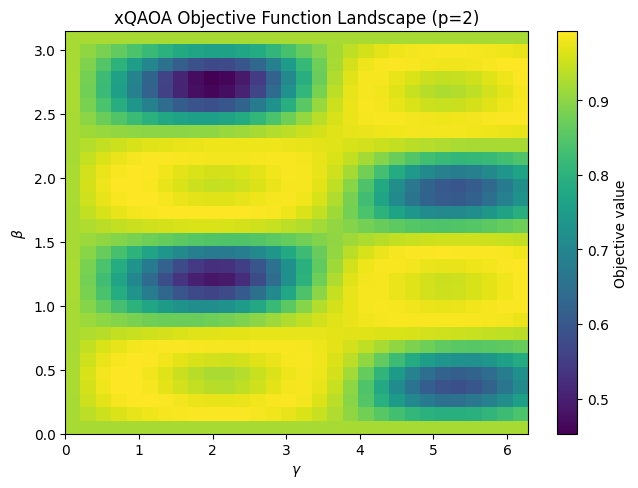

In [103]:
from collections import namedtuple
params = namedtuple("params",["p","beta","gamma", "max_cost"])
beta_range = np.linspace(0, np.pi, 30)
gamma_range = np.linspace(0, 2 * np.pi, 30)
trained_params_by_p=[]
p=1
ev = np.array(np.zeros((len(beta_range), len(gamma_range))), dtype=float)

# Because the lightcone is the same for all beta and gamma, we can precompute the lightcone decomposition of the cost function once.
# This will save a lot of time when we compute the expectation values over the grid of beta and gamma values.

gammas = [Parameter(f"gamma_{i}") for i in range(p)]
betas = [Parameter(f"beta_{i}") for i in range(p)]
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

for layer in range(p):
    qc = add_knapsack_cost_function(qc, values, gamma=gammas[layer])
    qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[layer])

circuit_params = qc.parameters

print("Decomposing the cost function using the lightcone method and a reference circuit...")
cost_fn = new_values_and_constraint_cost(values, weights, capacity)
reduced_cost_fn = light_cone_decomp_sparse_pauli(qc, cost_fn)
print(f"Decomposition complete. The polynomial reduced from {len(cost_fn.paulis)} to {len(reduced_cost_fn.get_support())} terms.")

test_qc = qc.copy()
with tqdm(total=len(beta_range) * len(gamma_range), desc="Computing cost functions") as pbar:
    for i,j in np.ndindex(len(beta_range), len(gamma_range)):
        #circ = qc.assign_parameters({qc.parameters[0]:0.43332312463307493 , qc.parameters[p]:2.1666156231653746}) # calculated previously
        circ=qc.assign_parameters({qc.parameters[0]: beta_range[i], qc.parameters[1]:gamma_range[j]})
        ev[i][j] = light_cone_estimate_Pauli_poly(reduced_cost_fn, circ)
        pbar.update(1)


# Computing some numbers from optimal solutions so we can normalize the plot.
# Using the all zeros bitstring as a reference point for the min of the constraints cost function, since it's hard to do worse.

print("\nAlmost done! Just computing some normalization constants...")
qc = QuantumCircuit(n)
cost_fn_min = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))
for i in range(n):
    if i in result_gurobi['selected_items']:
        qc.x(i)
cost_fn_max = light_cone_estimate_sparse_pauli(qc, new_values_and_constraint_cost(values, weights, capacity))

norm_ev = ((ev - cost_fn_min) / (cost_fn_max - cost_fn_min)).real

index = np.argmax(norm_ev)

a,b = np.unravel_index(index, norm_ev.shape)
trained_params_by_p.append(params(p=p, beta=beta_range[a], gamma=gamma_range[b], max_cost=norm_ev[a,b]))

plt.imshow(norm_ev, origin='lower', aspect='auto', cmap='viridis', extent = (0, 2 * np.pi, 0, np.pi))

cbar = plt.colorbar()

cbar.set_label('Objective value')
plt.tight_layout(rect=(0.0, 0.05, 1.0, 1.0))

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title("xQAOA Objective Function Landscape (p=2)")
plt.show()

### Let's also try and learn the optimal parameters

/Users/ibrahimshehzad/uc/lib/python3.13/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3409443.0898996186
       x: [ 2.133e+00  1.161e+00]
    nfev: 21
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3417702.3634524327
       x: [ 1.458e-01  2.440e+00]
    nfev: 21
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3392162.0561193707
       x: [ 9.471e-01  4.321e+00]
    nfev: 17
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3417747.7075609723
       x: [ 1.287e+00  6.283e+00]
    nfev: 20
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3428778.265817367
       x: [ 1.932e+00  8.190e-01]
    nfev: 22
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3393769.1407728903
       x: [ 2.152e+00  3.004e+00]
    nfev: 23
   maxcv: 0.0
 mess

/Users/ibrahimshehzad/uc/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ibrahimshehzad/uc/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


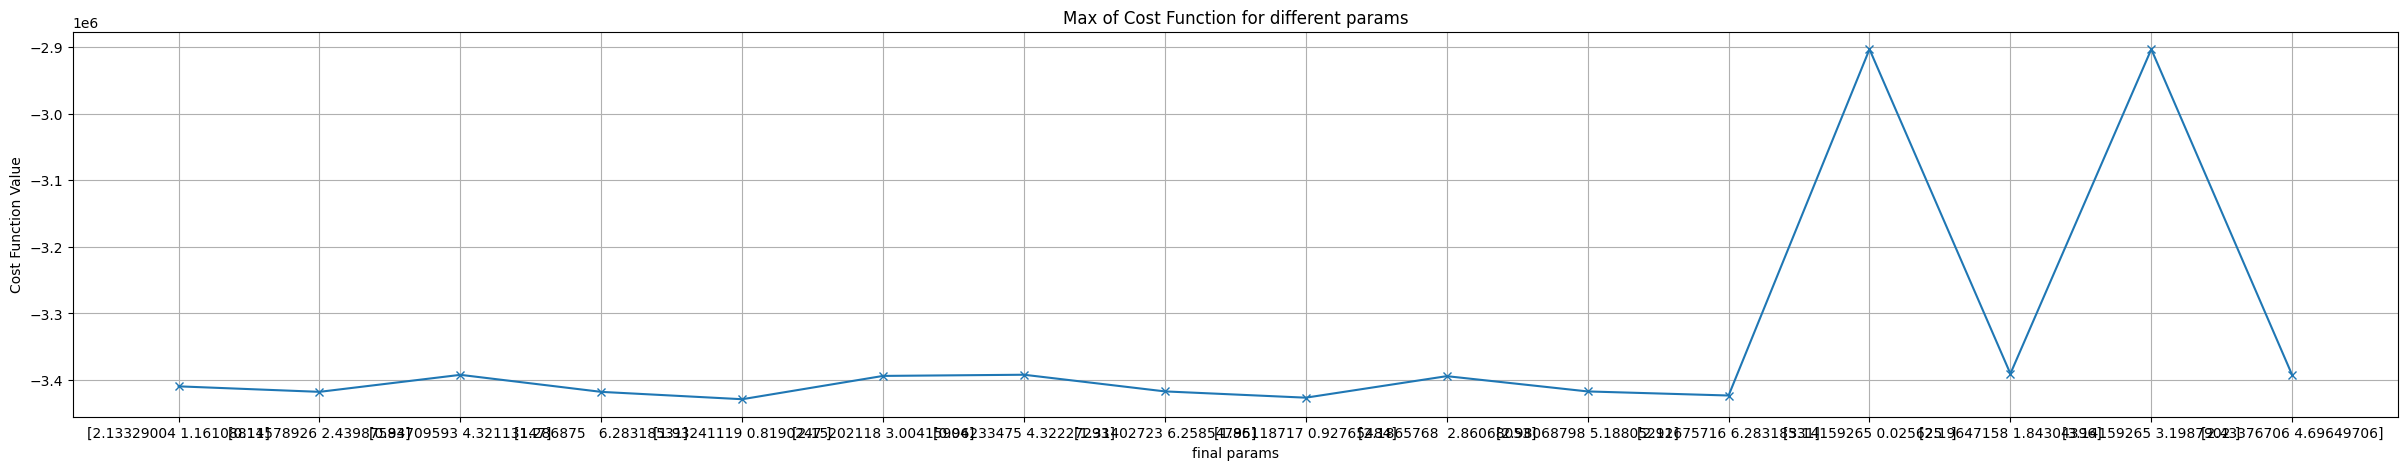

In [104]:
from scipy.optimize import minimize

qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)

for layer in range(p):
    qc = add_knapsack_cost_function(qc, values, gamma=gammas[layer])
    qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[layer])

obs=new_values_and_constraint_cost(values, weights, capacity)
reduced_cost_fn = light_cone_decomp_sparse_pauli(qc, obs)

def cost_to_minimize(params:list, qc:QuantumCircuit=qc, cost_fn:PauliPoly = reduced_cost_fn):
    circ = qc.copy()
    circ.assign_parameters(params, inplace=True)
    cost = light_cone_estimate_Pauli_poly(cost_fn, circ)
    return -cost

plt.figure(figsize=(30, 5))
x_vals= []
y_vals = []
max_iter = 4
for i in range(max_iter):
    for k in range(max_iter):
        init_params = [i*np.pi/(max_iter-1), 2*k*np.pi/(max_iter-1)] * p
        # Optimize
        result_lc = minimize(
        cost_to_minimize,
        init_params,
        args=qc,
        method="COBYLA",
        bounds=[(0, np.pi), (0, 2*np.pi)] * p,
        tol=1e-2,
        #options={"maxiter":100, "disp":True},
        )
        print(result_lc)
        y_vals.append(cost_to_minimize(list(result_lc.x)))
        x_vals.append((result_lc.x))
    
x_positions = list(range(len(x_vals))) 
x_labels_str = [str(t) for t in x_vals] 
plt.xticks(x_positions, x_labels_str)
plt.plot(y_vals,marker='x')
plt.xlabel("final params")
plt.ylabel("Cost Function Value")
plt.title("Max of Cost Function for different params")
plt.grid(True)
plt.show()

In [105]:
np.argmin(y_vals)
x_vals[9]

array([2.1865768 , 2.86068053])

In [106]:
y_vals[9]

np.complex128(-3394143.978318316-0j)

#### xQAOA sampling results

In [ ]:
shots=100_000
filter_sols = True
#obtained_params= list(zip([x.beta for x in trained_params_by_p if x.p==2], [x.gamma for x in trained_params_by_p if x.p==2]))

xp_circ = pm.run(qc.assign_parameters({"beta_0": 2.1865768,
                                                "gamma_0": 2.86068053}))
                                               # "beta_1": 2*np.pi/30,
                                               # "gamma_1":10*np.pi/30})
                                                # "beta_1":obtained_params[0][0],
                                                #  "gamma_1": obtained_params[0][1]}) # optimal params found above

tr=values_only_cost(values=values)
test_ev = estimator_mps.run([(xp_circ, tr.apply_layout(xp_circ.layout))])
print(test_ev.result()[0].data.evs)

xp_circ.measure_active()
job = sampler_mps.run([(xp_circ,)], shots=shots)    
counts_int_lc = job.result()[0].data.meas.get_int_counts()
counts_bin_lc = job.result()[0].data.meas.get_counts()


counts_bin_lc_rev = {} 
for key in counts_bin_lc.keys():
    reversed_key = key[::-1]
    counts_bin_lc_rev[reversed_key] = counts_bin_lc[key]


dict_bit_values_lc = convert_bitstring_to_values(counts_bin_lc_rev, values, weights, capacity,
                                            filter_invalid_solutions=True)

#Sort the dictionary by value
sorted_dict = dict(sorted(dict_bit_values_lc.items(), key=lambda item: item[0], reverse=True))
best_value = max(sorted_dict.keys())
best_count = sorted_dict[best_value]
print(f"Best value: {best_value}")

approx_ratio = compute_approximate_ratio(dict_bit_values_lc, optimal_value)

print(f'Approximate ratio: {approx_ratio}')

-16365.3618963395


Processing bitstrings: 100%|██████████| 100000/100000 [00:01<00:00, 55363.10it/s]

Best value: 12092.593216496074
Approximate ratio: 0.9068490481770666


### Warm start sampling results

In [109]:
warm_start_counts = defaultdict(int)

for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in qubit_ordered_distribution)
    warm_start_counts[bitstring] += 1

dict_bit_values_ws = convert_bitstring_to_values(warm_start_counts, values, weights, capacity,
                                                   filter_invalid_solutions=filter_sols)

# Compute the probability of sucess
p_sucess_ws= probabilty_success(dict_bit_values_ws, optimal_value)
approx_ratio_ws = compute_approximate_ratio(dict_bit_values_ws, optimal_value)
print(f"Best WS value: {max(dict_bit_values_ws.keys())}")
print(f"WS approx ratio {approx_ratio_ws}")

Processing bitstrings: 100%|██████████| 99992/99992 [00:02<00:00, 43936.12it/s]

Best WS value: 12083.665805608312
WS approx ratio 0.7322541120638281


#### Random Sampling results

In [110]:
random_counts = defaultdict(int)
for _ in range(shots):
    bitstring = ''.join(str(x) for x in np.random.randint(2, size=n))
    random_counts[bitstring] += 1


dict_bit_values_random = convert_bitstring_to_values(random_counts, values, weights, capacity,
                                                     filter_invalid_solutions=filter_sols)

# Compute the probability of success
approx_ratio_random = compute_approximate_ratio(dict_bit_values_random, optimal_value)
print(f"Best rand value: {max(dict_bit_values_random.keys())}")
print(f"Rand approx ratio {approx_ratio_random}")

Processing bitstrings: 100%|██████████| 100000/100000 [00:01<00:00, 84636.09it/s]

Best rand value: 11920.71449608991
Rand approx ratio 0.9721894047103495


#### Plots for comparison

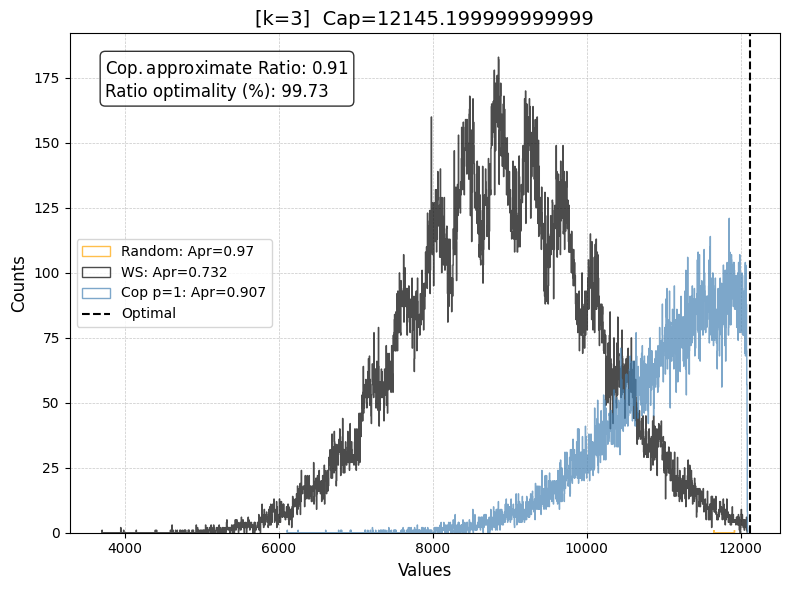

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '[k=3]  Cap=12145.199999999999'}, xlabel='Values', ylabel='Counts'>)

In [111]:
from scripts.utils.visualize import plot_multiple_distributions

data_dict = {
    f"Random: Apr={approx_ratio_random:.2f}": dict_bit_values_random,
   f"WS: Apr={approx_ratio_ws:.3f}": dict_bit_values_ws,
   f"Cop p=1: Apr={approx_ratio:.3f}": dict_bit_values_lc,
}
# Custom colors
colors = {
    f"Random: Apr={approx_ratio_random:.2f}": "orange",
    f"WS: Apr={approx_ratio_ws:.3f}": 'black',
    f"Cop p=1: Apr={approx_ratio:.3f}": "steelblue",
}    
# Annotations
annotations = {
    r"$\mathrm{Cop. approximate\ Ratio}$": np.round(approx_ratio, 2),
    "Ratio optimality (%)": np.round(best_value /optimal_value *100, 2),
}
plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=2000,
    log=False,
    annotations=annotations,
    figsize=(8, 6),
    title=f"[k={k}]  Cap={capacity}"
)